In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns
import re
from datetime import datetime
from wordcloud import WordCloud
from PIL import Image

sns.set_style('whitegrid')
%matplotlib inline

In [137]:
cols = ['country', 'visited', 'reviewed', 'reviewer_age', 'experience', 'location', 'rating', 'review']

df = pd.read_csv('touroperator_ratings.csv' , delimiter = '\t', header = None)

df.columns = cols

df.drop(df[(df.review.isnull()) ].index, axis = 0, inplace = True)

df['review_len'] = df.review.apply(len)

#df[(df.review.isnull()) ] #.shape, 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16291 entries, 0 to 16291
Data columns (total 9 columns):
country         16291 non-null object
visited         16291 non-null object
reviewed        16291 non-null object
reviewer_age    13734 non-null object
experience      13734 non-null object
location        16291 non-null object
rating          16291 non-null int64
review          16291 non-null object
review_len      16291 non-null int64
dtypes: int64(2), object(7)
memory usage: 1.2+ MB


- There are well over 16,291 reviewes in the dataset
- Both experience and age have null values for 2557 records

In [5]:
df.head(3)

,country,visited,reviewed,reviewer_age,experience,location,rating,review,review_len
0,Germany,Visited: July 2018,"Reviewed: Aug 20, 2018",35-50 years of age,Experience level: first safari,About: Land and Lake Safaris,5,"Before we started, we were in contact with lan...",434
1,Germany,Visited: July 2018,"Reviewed: Aug 20, 2018",50-65 years of age,Experience level: first safari,About: African Jackal,5,I am german- sorry for my english .-) Our crew...,2037
2,Singapore,Visited: August 2018,"Reviewed: Aug 20, 2018",35-50 years of age,Experience level: over 5 safaris,About: The Luxury Safari Company,5,We decided at pretty late notice to go on safa...,337


In [6]:
def clean_dates(x):
    pattern = re.compile(r'(?:\w+\:\s)(?P<visited>.*)')
    try:
        match = re.search(pattern, x) #df.loc[0, 'visited'])
        if match:
            res = match.group('visited')
            return res
    except TypeError:
        return np.nan

In [7]:
#Get the date values from the column
df['visited'] = df['visited'].apply(clean_dates)
df['reviewed'] = df['reviewed'].apply(clean_dates)

#Convert the processed values to proper dates
df['visited'] = df['visited'].apply(lambda x: datetime.strptime(x, '%B %Y'))
df['reviewed'] = df['reviewed'].apply(lambda x: datetime.strptime(x, '%b %d, %Y'))

#Clean location
df['location'] = df['location'].apply(clean_dates)

#clean experience
df['experience'] = df['experience'].apply(clean_dates)

In [8]:
df.head(3)

,country,visited,reviewed,reviewer_age,experience,location,rating,review,review_len
0,Germany,2018-07-01,2018-08-20,35-50 years of age,first safari,Land and Lake Safaris,5,"Before we started, we were in contact with lan...",434
1,Germany,2018-07-01,2018-08-20,50-65 years of age,first safari,African Jackal,5,I am german- sorry for my english .-) Our crew...,2037
2,Singapore,2018-08-01,2018-08-20,35-50 years of age,over 5 safaris,The Luxury Safari Company,5,We decided at pretty late notice to go on safa...,337


In [54]:
def apply_labels(bars, values, fsize= 8):
    for bar, val in zip(bars, values):
        h = bar.get_height()
        w = bar.get_width()
        xtick_lock = bar.get_x()
        ax.text(x= xtick_lock + w /2, y = h + 5, s = val, ha='center', va='bottom', fontsize = fsize)

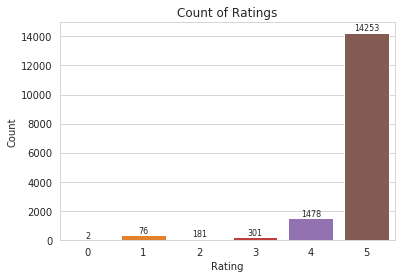

In [55]:
rating_dist = df.rating.value_counts().sort_values()

rating_dist
label = rating_dist.index
values = rating_dist.values
ax = sns.barplot(label, values)
bars = ax.patches

apply_labels(bars, values)
plt.title("Count of Ratings") ; plt.xlabel("Rating") ; plt.ylabel("Count")
plt.show()

- Ratings are mainly in 4 and 5 star 

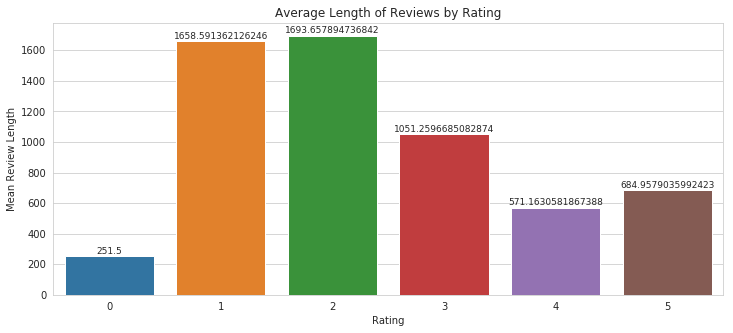

In [61]:
text_len = df.groupby('rating')['review_len'].mean()

plt.figure(figsize=(12, 5))
ax = sns.barplot(text_len.index, text_len.values)
bars = ax.patches
values = text_len.values
apply_labels(bars, values, fsize = 9)

plt.title('Average Length of Reviews by Rating')
plt.xlabel('Rating')
plt.ylabel('Mean Review Length')
plt.show()

- Reviews with ratings 1 or 2 have the longest reviews on average.
- Reviews with rating of 0 are generally brief in length.

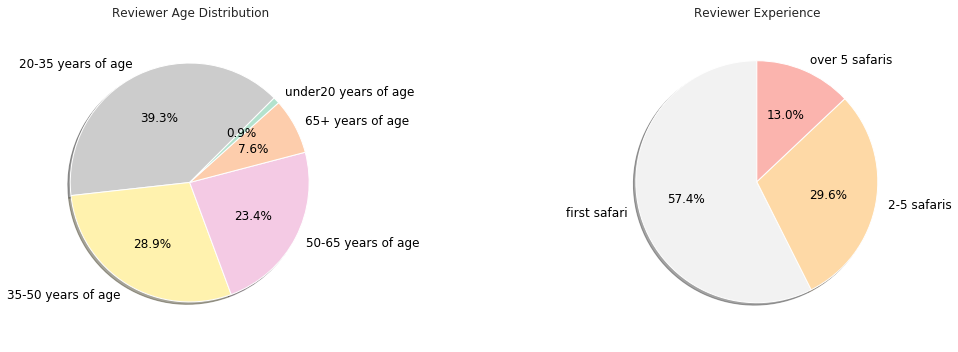

In [16]:
plt.figure(figsize = (12, 5))

plt.subplot(1, 3, 1)
age_dist = df.reviewer_age.value_counts()
cmap = plt.get_cmap('Pastel2_r')
c = [cmap(i) for i in np.linspace(0, 1, len(age_dist.index))]
plt.pie(age_dist.values, labels= age_dist.index, colors= c, 
        shadow= True, autopct= '%1.1f%%', startangle = 45, textprops = {'color': 'black', 'fontsize': 12})
plt.axis('equal')
plt.title("Reviewer Age Distribution")

plt.subplot(1, 3, 3)
experience_dist = df.experience.value_counts()
cmap = plt.get_cmap('Pastel1_r')
c = [cmap(i) for i in np.linspace(0, 1, len(experience_dist.index))]
plt.pie(experience_dist.values, labels= experience_dist.index, colors= c, 
        shadow= True, autopct= '%1.1f%%', startangle = 90, textprops = {'color': 'black', 'fontsize': 12})
plt.axis('equal')
plt.title("Reviewer Experience")

#plt.show()
plt.tight_layout()

- Age group of 20 - 35 is the modal class with under 20 having just about 1% of the total.
- The reviewes were mostly from first timeers in safari.

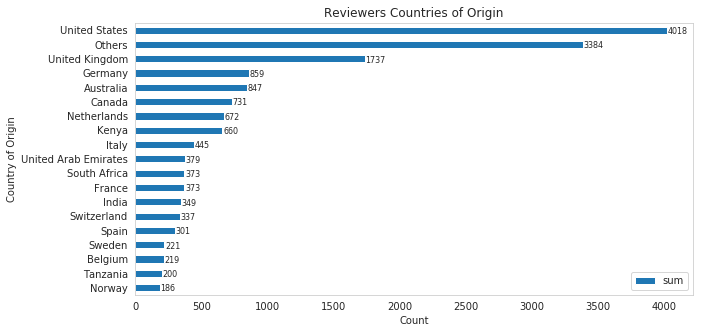

In [95]:
country_counts = df.groupby('country', 
                            as_index = False)['visited'].count().sort_values('visited',
                                                                             ascending = False)
country_counts['cum_sum'] = country_counts['visited'].cumsum() / country_counts['visited'].sum()

#Group Countries Below the 80th Percentile
def reduce_categories(data, cat_group, cum_sum, percent_limit = 0.75):
    for i in range(0, data.shape[0]):
        if data.loc[i, cum_sum] < percent_limit:
            data.loc[i, 'new_label'] = data.loc[i, cat_group]
        else:
            data.loc[i, 'new_label'] = 'Others'

reduce_categories(country_counts, cat_group= 'country', cum_sum= 'cum_sum', percent_limit= 0.80)

country_c = country_counts.groupby('new_label').visited.agg([np.sum]).sort_values(by = 'sum', 
                                                                      ascending = True)

label = country_c.index.tolist()
values = country_c.values.flatten().tolist()

ax = country_c.plot(kind = 'barh', grid = False, figsize = (10, 5))
bars = ax.patches
for bar, val in zip(bars, values):
    h = bar.get_height()
    w = bar.get_width()
    ytick_lock = bar.get_y()
    ax.text(x= w+5, y = ytick_lock, s = val, ha='left', va='baseline', fontsize = 8)
plt.title('Reviewers Countries of Origin')
plt.ylabel('Country of Origin')
plt.xlabel('Count')
plt.show()

- The highest number of reviews were recorded from citizens of the United States.
- Norway had the least number of citizens in the top 20 countries.

In [18]:
#pd.pivot_table(df, values= 'country', index = 'rating', column )

df[['rating','location', 
    'country']].groupby(['rating',
                         'location']).count().groupby(level = 0, group_keys = False).\
apply( lambda x : x.nlargest(5, 'country'))

country
rating location                                    
0      Classic Journeys Africa                    1
       Encompass Africa                           1
1      It Started in Africa                      11
       Solaris Tours and Safaris                  9
       Bonfire Adventures                         8
       Bush Baby Calls                            7
       Sandland Tours and Safaris                 7
2      Africa Travel Co                           2
       Africa Zim Travel & Tours                  2
       Bobby Tours Tanzania Safaris               2
       Kapolondo Expeditions                      2
       Karibu Safaris In Kenya                    2
3      Lake Manyara National Park                10
       Tanzania                                   7
       Karibu Safaris In Kenya                    4
       Queen Elizabeth National Park              4
       Safarihub                                  4
4      Kenya                                     45
       Karibu Safaris In Kenya                   39
       Tanzania                                  37
       Safarihub                                 34
       Safari.com                                23
5      Safarihub                                441
       Tanzania                                 249
       Kenya                                    199
       South Africa                             159
       Kenya Walking Survivors Safaris Ltd      156

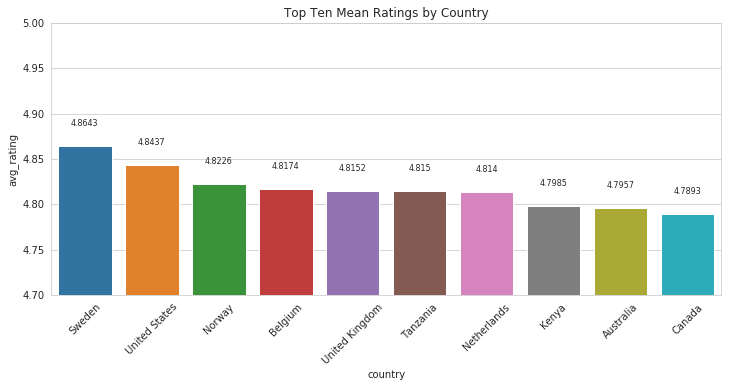

In [107]:

country_rating = (df.groupby('country', as_index = False).
                  rating.agg([np.mean,np.size]).
                  reset_index().sort_values(['mean', 'size'],
                                            ascending = [False, False])
                 )

country_r = country_rating[country_rating.country.isin(country_c.index)]
country_r.columns = ['country', 'avg_rating', 'rating_count']


fig = plt.figure(figsize = (12, 5))

#ax1 = fig.add_subplot(111)
ax = sns.barplot(x = country_r.iloc[:10, :].country, y = country_r.iloc[:10, :].avg_rating)

values = country_r.iloc[:10, :].avg_rating.round(4)
bars = ax.patches
for bar, val in zip(bars, values):
    h = bar.get_height()
    w = bar.get_width()
    xtick_lock = bar.get_x()
    ax.text(x= xtick_lock + w /2, y = h + .02, s = val, ha='center', va='bottom', fontsize = 8)
#apply_labels(bars, values)

ax.set_title("Top Ten Mean Ratings by Country")
ax.set_ylim(ymin = 4.7, ymax = 5.0)
plt.xticks(rotation = 45)
plt.show()

- Sweden had the highest average mean rating considering the number of reviews too.
- Canada closed the top ten mean ratings by countries of origin.

## What month of the year do people mostly go for safaris ?

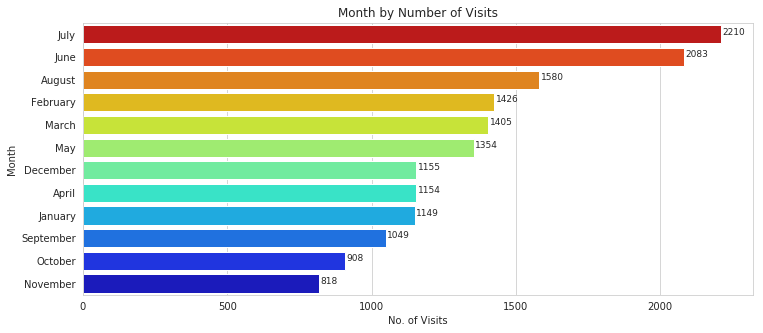

In [136]:
visit_month = df.visited.apply(lambda x: datetime.strftime(x, "%B")).value_counts().to_frame().reset_index()
visit_month.columns = ['month', 'visited']


plt.figure(figsize = (12, 5))
ax = sns.barplot(y = visit_month.month, x = visit_month.visited, palette = 'jet_r')

bars = ax.patches
values = visit_month.visited
for bar, val in zip(bars, values):
    h = bar.get_height()
    w = bar.get_width()
    ytick_lock = bar.get_y()
    ax.text(x= w+6, y = ytick_lock + h/2 , s = val, ha='left', va='baseline', fontsize = 9)

plt.title('Month by Number of Visits')
plt.xlabel('No. of Visits')
plt.ylabel('Month')
plt.show()

## Cleaning The Text

In [121]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

lemma = WordNetLemmatizer()
stemmer = PorterStemmer()
def clean_reviews(text):
    #pattern = re.compile(r'[^\w+]')
    reviews = re.sub(r'\W', ' ', str(text))                ## remove special characters
    reviews = re.sub(r'\s+[a-zA-Z]\s+', ' ', str(reviews))    #remove all single characters
    reviews = re.sub(r'\^[a-zA-Z]\s+', ' ',  reviews)         #remove single characters from the from
    reviews = re.sub(r'\s+', ' ', reviews, flags= re.I)       #substitute mutiple spaces with a single space
    reviews = re.sub(r'^b\s+', '', reviews)                   #Remove prefixed 'b'
    reviews = text.lower()
    reviews = reviews.split()
    
    reviews = [lemma.lemmatize(word) for word in reviews if word not in stopwords.words('english')]
#    reviews = [stemmer.stem(word) for word in reviews if word not in stopwords.words('english')]
    reviews = " ".join(reviews)
    
    return reviews

In [123]:

corpus = df.review.apply(clean_reviews)

corpus[:10]

0    started, contact land & lake question friendly...
1    german- sorry english .-) crew consisted charl...
2    decided pretty late notice go safari celebrate...
3    boyfriend tok 5 day safari maasai mara, lake n...
4    satisfied level service communication discover...
5    nicholas (the guy spoke trip / made booking) s...
6    booked gorilla safari bwindi impenetrable fore...
7    successful tour zimbabwe, excellently organize...
8    first telephone conversation rob morley tailor...
9    safari life experience requires adequate plann...
Name: review, dtype: object

### Applying TruncatedSVD

In [124]:
from sklearn.feature_extraction.text  import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

#Term Frequency
tfidf = TfidfVectorizer(ngram_range = (1, 3))
X = tfidf.fit_transform(corpus)

#Preprocessing using TruncatedSVD
lsa = TruncatedSVD(n_components = 10, n_iter = 100, random_state = 0)
lsa.fit(X)


terms = tfidf.get_feature_names()

for ind, comp in enumerate(lsa.components_):
    terms_to_comp = zip(terms, comp)
    sorted_terms = sorted(terms_to_comp, key = lambda x:x[1], reverse = True )[:10]
    print('concept : {}'.format(ind))
    for term in sorted_terms:
        print( term[0])
    print()

concept : 0
safari
trip
day
tour
great
guide
experience
time
good
would

concept : 1
park
day
beautiful
see
animal
national
lake
national park
saw
serengeti

concept : 2
beautiful
trip
africa
uganda
park
gorilla
south
south africa
national park
national

concept : 3
beautiful
good
great
nice
service
excellent
park
communication
lot
guide

concept : 4
beautiful
mara
masai
masai mara
kenya
nakuru
lake nakuru
amazing
uganda
lake

concept : 5
safari
amazing
experience
great
tanzania
everything
serengeti
beautiful
saw
big

concept : 6
good
beautiful
trip
service
camp
communication
lodge
hotel
drive
nice

concept : 7
beautiful
tour
tanzania
day
company
serengeti
safari
ngorongoro
manyara
crater

concept : 8
excellent
service
beautiful
safari
park
national
national park
communication
highly
serengeti

concept : 9
great
trip
uganda
gorilla
lake
national park
national
park
everything
well



## Words by Rating

In [125]:
def plotWordCloud(data, title, cmap = 'viridis', figsize =(12, 12)):
    wc = WordCloud(
        background_color = 'white',
        #stopwords = STOPWORDS,
        max_words = 200, max_font_size = 50,
        relative_scaling = .6,
        normalize_plurals = True,
        collocations = False,
        colormap = cmap
    ).generate(data)
    
    plt.figure(figsize = figsize)
    plt.grid(False)
    plt.imshow(wc)
    plt.title(title)
    plt.show()

#Add o the dataframe 
df['corpus'] = corpus

## 5 Star Ratings 

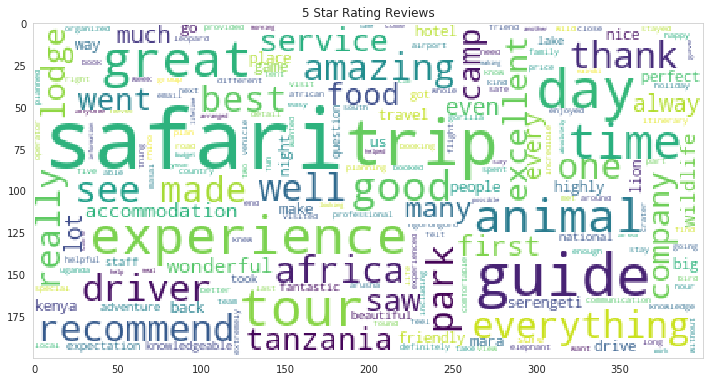

In [126]:
five_star = df[df.rating == 5]['corpus'].str.cat(sep = ",")
plotWordCloud(five_star, title = '5 Star Rating Reviews')

## 4 Star Ratings

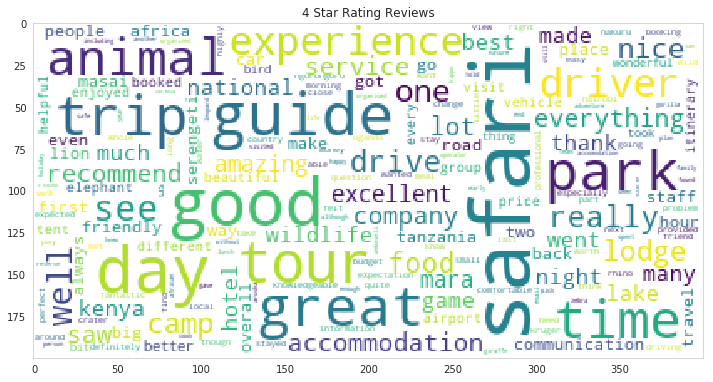

In [127]:
four_star = df[df.rating == 4]['corpus'].str.cat(sep = ",")
plotWordCloud(four_star, title = '4 Star Rating Reviews')

## 3 Star Ratings

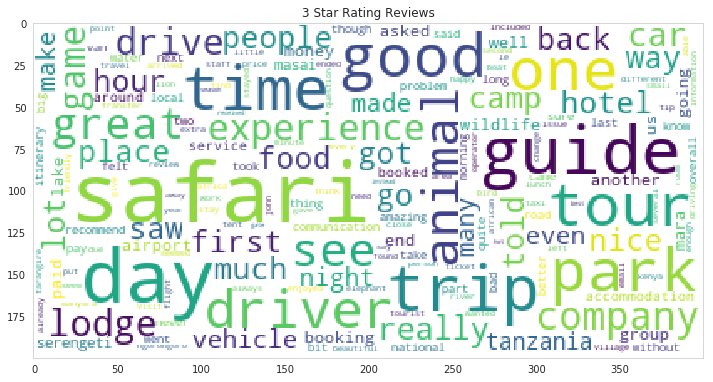

In [128]:
three_star = df[df.rating == 3]['corpus'].str.cat(sep = ",")
plotWordCloud(three_star, title = '3 Star Rating Reviews')

## 2 Star Ratings

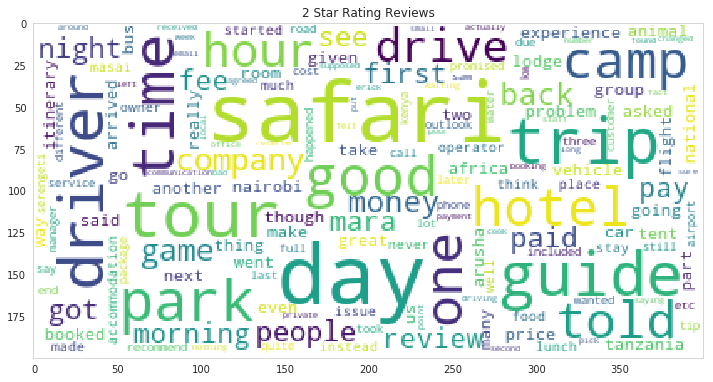

In [129]:
two_star = df[df.rating == 2]['corpus'].str.cat(sep = ",")
plotWordCloud(two_star, title = '2 Star Rating Reviews')

## 1 Star Ratings

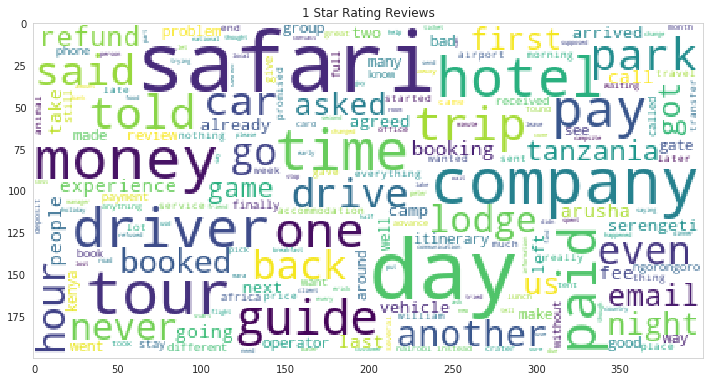

In [130]:
one_star = df[df.rating == 1]['corpus'].str.cat(sep = ",")
plotWordCloud(one_star, title = '1 Star Rating Reviews')